In [141]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [180]:
%load_ext autoreload
%autoreload 2
from helpers.constants import *
from helpers.file_manipulation import *
from helpers.loss_functions import *
from helpers.submission import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
SAVE_DIR = MODELS_SAVE_DIR + 'unet_2'
model = tf.keras.models.load_model(SAVE_DIR, 
                                   custom_objects={'dice_coef_loss': dice_coef_loss, 
                                                   'dice_coef': dice_coef})

In [181]:
predict_submissions(model)

Loading data/test_set_images/: 100%|██████████| 50/50 [00:01<00:00, 25.05it/s]


Predicting test images...


KeyboardInterrupt: 

In [177]:
def predict_submissions(model):
    #Load 608x608 test images 
    images608 = load_test_images()
    
    #Split each of them into 4 400x400 images
    images400 = split_608_to_400(images608)
    
    #Predict their mask
    print("Predicting test images...")
    with tf.device('/cpu:0'):
        masks400 = model.predict(images400).squeeze()
    
    print(masks400.shape)
    #Merge the 4 400x400 masks into one 608x608 by averaging the overlapping parts
    masks608 = merge_masks400(masks400)
    
    # binarize predictions into 0's and 1's
    masks608 = np.asarray([(mask >= ROAD_THRESHOLD_PIXEL_PRED) * 1.0 for mask in masks608])

    #Convert mask to patch labels into file submission.csv
    now = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    if not os.path.isdir(PREDICTIONS_SAVE_DIR):
        os.mkdir(PREDICTIONS_SAVE_DIR)
    make_prediction(masks, filename=f"{PREDICTIONS_SAVE_DIR}submission_{now}.csv")
    
    # Write the masks to folder
    write_predictions(masks)

In [110]:
def merge_masks400(masks400):
    """
    Merge 4 400x400 masks where images of the list `[img1,img2,img3,img4, ...]` corresponds to the following order:
    | img1 | img2 |
    | img3 | img4 | into a 608x608 mask. Overlapping parts are averaged among the predictions.
    :params masks400: list of 400x400 masks, where each consecutive 4 masks corresponds to a 608x608 mask
    """
    if len(masks400) % 4 != 0:
        raise ValueError("Number of 400x400 predictions is not a mulitple of 4.")

    thres1 = TRAINING_IMG_SIZE #End of the top-left masks
    thres2 = TEST_IMG_SIZE - TRAINING_IMG_SIZE #Start of the bottom-right masks
    thres3 = thres1 - thres2
    
    list_masks608 = []
    for idx in range(0, len(masks400), 4):
        mask608 = np.empty((TEST_IMG_SIZE, TEST_IMG_SIZE), dtype='float32') #initialize a 608x608 mask
        img1, img2, img3, img4 = [masks400[idx + i] for i in range(4)]
        
        #Copy parts that belong to a single mask into the final mask, 
        #These parts correspond to the corner of the final mask
        mask608[:thres2, :thres2] = img1[:thres2, :thres2]
        mask608[:thres2, thres1:] = img2[:thres2, thres3:]
        mask608[thres1:, :thres2] = img3[thres3:, :thres2]
        mask608[thres1:, thres1:] = img4[thres3:, thres3:]
        
        #Average parts taht belong to multiple masks
        mask608[:thres2, thres2:thres1] = (img1[:thres2, thres2:] + img2[:thres2, :thres3]) / 2
        mask608[thres2:thres1, :thres2] = (img1[thres2:, :thres2] + img3[:thres3, :thres2]) / 2
        mask608[thres2:thres1, thres2:thres1] = (img1[thres2:, thres2:] + img2[thres2:, :thres3] +
                                                img3[:thres3,thres2:] + img4[:thres3, :thres3]) / 4
        mask608[thres2:thres1, thres1:] = (img2[thres2:, thres3:] + img4[:thres3, thres3:]) / 2
        mask608[thres1:, thres2:thres1] = (img3[thres3:, thres2:] + img4[thres3:, :thres3]) / 2
        list_masks608.append(mask608)
    return list_masks608

[(0, 0, 1),
 (16, 0, 0),
 (32, 0, 0),
 (48, 0, 0),
 (64, 0, 0),
 (80, 0, 0),
 (96, 0, 0),
 (112, 0, 0),
 (128, 0, 0),
 (144, 0, 0),
 (160, 0, 0),
 (176, 0, 0),
 (192, 0, 0),
 (208, 0, 0),
 (224, 0, 0),
 (240, 0, 0),
 (256, 0, 0),
 (272, 0, 0),
 (288, 0, 0),
 (304, 0, 0),
 (320, 0, 0),
 (336, 0, 0),
 (352, 0, 0),
 (368, 0, 0),
 (384, 0, 0),
 (0, 16, 0),
 (16, 16, 0),
 (32, 16, 0),
 (48, 16, 0),
 (64, 16, 0),
 (80, 16, 0),
 (96, 16, 0),
 (112, 16, 0),
 (128, 16, 0),
 (144, 16, 0),
 (160, 16, 0),
 (176, 16, 0),
 (192, 16, 0),
 (208, 16, 0),
 (224, 16, 0),
 (240, 16, 0),
 (256, 16, 0),
 (272, 16, 0),
 (288, 16, 0),
 (304, 16, 0),
 (320, 16, 0),
 (336, 16, 0),
 (352, 16, 0),
 (368, 16, 0),
 (384, 16, 0),
 (0, 32, 1),
 (16, 32, 0),
 (32, 32, 0),
 (48, 32, 0),
 (64, 32, 0),
 (80, 32, 0),
 (96, 32, 0),
 (112, 32, 0),
 (128, 32, 0),
 (144, 32, 0),
 (160, 32, 0),
 (176, 32, 0),
 (192, 32, 0),
 (208, 32, 0),
 (224, 32, 0),
 (240, 32, 0),
 (256, 32, 0),
 (272, 32, 0),
 (288, 32, 0),
 (304, 32, 0),

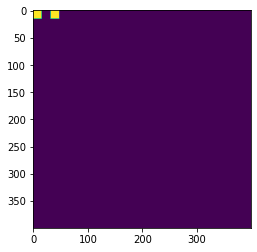

In [164]:
img1 = np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32')
img1[:16, :16] = 1
img1[:16, 32:48] = 1
plt.imshow(img1)

make_patch_list(img1)

Test 1


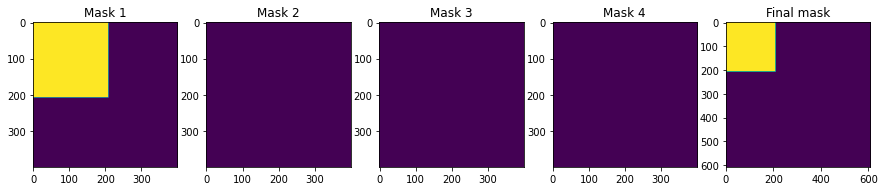

Test 2


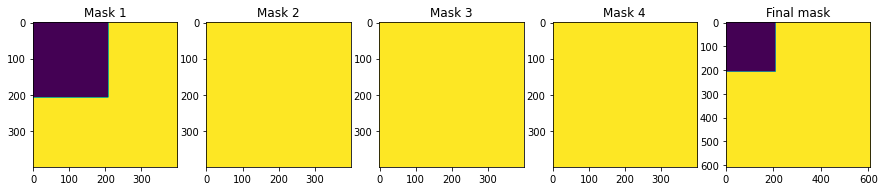

Test 3


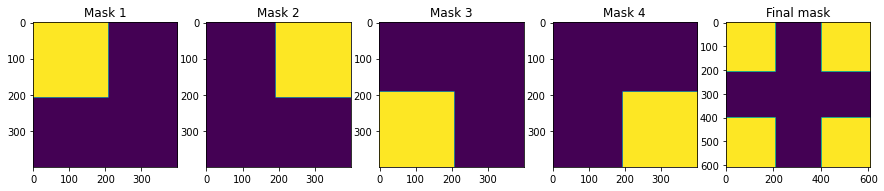

Test 4


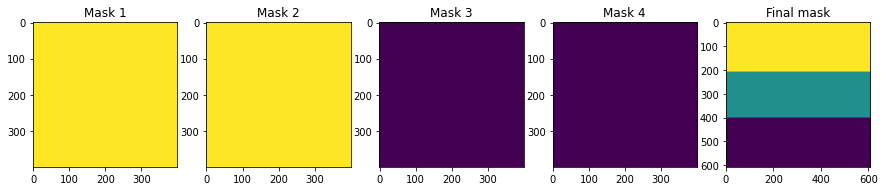

Test 5


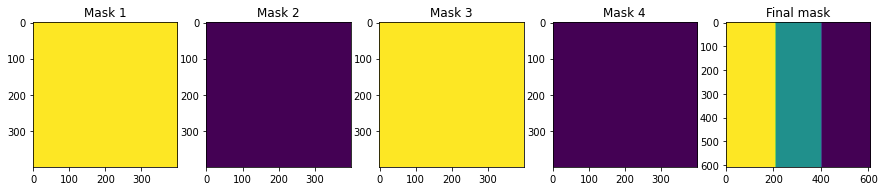

Test 6


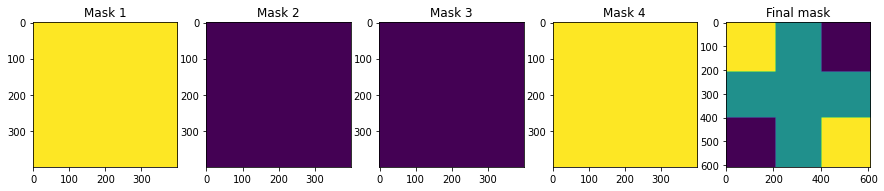

In [84]:
def plot_small_and_final_masks(small_masks):
        final_mask = merge_masks400(small_masks)[0]
        fig, axes = plt.subplots(1,5, figsize=(15,10))
        for i, mask in enumerate(small_masks):
            axes[i].imshow(mask,vmin=0, vmax=1)
            axes[i].set_title(f"Mask {i+1}")
        axes[4].imshow(final_mask,vmin=0, vmax=1)
        axes[4].set_title("Final mask")
        plt.show()

def test_merge_masks400():
    thres1 = TRAINING_IMG_SIZE #End of the top-left masks
    thres2 = TEST_IMG_SIZE - TRAINING_IMG_SIZE #Start of the bottom-right masks
    thres3 = thres1 - thres2
    
    print("Test 1")
    img1,img2,img3,img4 = [np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(4)]
    img1[:thres2, :thres2] = 1
    plot_small_and_final_masks([img1,img2,img3,img4])
    
    print("Test 2")
    img1,img2,img3,img4 = [np.ones((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(4)]
    img1[:thres2, :thres2] = 0
    plot_small_and_final_masks([img1,img2,img3,img4])
    
    print("Test 3")
    img1,img2,img3,img4 = [np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(4)]
    img1[:thres2, :thres2] = 1
    img2[:thres2, thres3:] = 1
    img3[thres3:, :thres2] = 1
    img4[thres3:, thres3:] = 1
    plot_small_and_final_masks([img1,img2,img3,img4])
    
    print("Test 4")
    img1,img2  = [np.ones((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    img3,img4 = [np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    plot_small_and_final_masks([img1,img2,img3,img4])
    
    print("Test 5")
    img1,img3  = [np.ones((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    img2,img4 = [np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    plot_small_and_final_masks([img1,img2,img3,img4])
    
    print("Test 6")
    img1,img4  = [np.ones((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    img2,img3 = [np.zeros((TRAINING_IMG_SIZE, TRAINING_IMG_SIZE), dtype='float32') for i in range(2)]
    plot_small_and_final_masks([img1,img2,img3,img4])
        
test_merge_masks400()

In [22]:
def split_608_to_400(images608):
    """
    Split a 608x608 image into 4 400x400 images in the following order:
    | 1 | 2 |
    | 3 | 4 |
    :param images608: list of 608x608 images
    """
    thres1 = TRAINING_IMG_SIZE #End of the top-left masks
    thres2 = TEST_IMG_SIZE - TRAINING_IMG_SIZE #Start of the bottom right masks
    
    images400 = []
    for img in images608:
        images400.append(img[:thres1,:thres1])
        images400.append(img[:thres1,thres2:])
        images400.append(img[thres2:,:thres1])
        images400.append(img[thres2:,thres2:])
    return np.asarray(images400)

images400 = split_608_to_400(images608)
images400.shape

(200, 400, 400, 3)